# Back / Foreground separation
In this notebook we try to detect background pixels and remove them from image in order to keep only objets with different colour that, in our case, would be the panel we must operate on.\
We tested here the main idea, tuned the parameter for an optimal output, and then we will extend that to real scenario.\
This code is organized as follow:

**input:** single frame extracted from video stream

**output:** image of panel(ROI) with few other elements, polarized background
1. **decide when there is no panel in sight**: histogram distribution
2. **sample image to extract background color**: use mean/camshift to reach a particularly populated area wrt certaint distribution of pixels
3. **extract background pixel from the image**: backprojection
4. **result improvement**



using background subtraction library, calculating background as the mean of various images (i.e. extracted frames from a video of the surraounding

In [126]:
# INCLUDE
####
# IMAGE STREAM ACQUISITION
#    video stream management?(elsewhere)
#.    first/usefull frames memorization
#    video stream (general) filtering
#
####
# IMAGE FILTERING/CONVERSION FOR COLOR ENHANCEMENT
#..    hsv space used (least inlfuence from environmental changes)
#    filtering for lowering noise/luminosity peaks
#    color clustering on histogram?
#    colored rocks recognition?
#
####
# SOURCE HISTOGRAMS
####
# hist params
####
#..    computatation
#..    normalization
#
####
# ROIs DEFINITION AND HISTOGRAMS
####
# CFD comparing methods and parameters
####
#    roi identification: 
#..       - samples library
#       - extraction from stream source:
#..           1) hardcoded dimension/ proportion of source's dimension
#.           2) rnd points/size
#           3) adaptive wrt source's features
#.           4) manual (human)
## watershed/clustering for regions segmentation
#
####
# ADAPTIVE MASK
####
# parameters
## moved inside roi definition method because are dipending by that
## may be adaptable from roi dimension
#    roi hist filtering?
#.    roi histogram correllation testing:
#..        1) pass/non pass test to eliminate low correlated samples
#        2) mask weight proportional to correlation
#..    backprojection mask
#..    structuring element for planar filtering
#..    back/foreground separation
#
####
# MASK IMPROVEMENT
#    biggest contiguous region (as it could be the panel)
#    foreground filtering?
#    mini blobs remotion, especially in less/most transformed areas
#
##moved to next step



In [4]:
def bgVStream(srcBgVS,srcMode='single'):
    if srcMode=='single':
        return cv.imread(srcBgVS)
    elif srcMode=='video':
        cap = cv.VideoCapture(srcBgVS)
        if cap.isOpened():
            _, capFrame = cap.read()
        cap.release()
        return capFrame

In [10]:
def bgPreFilt(srcBgPF,paramBgPF=cv.COLOR_BGR2HSV):
    return cv.cvtColor(srcBgPF,paramBgPF)

In [ ]:
def bgForeMask(image2mask,roiLibrary,maskParam=0):

In [24]:
# import numpy as np
# import cv2 as cv
# import matplotlib.pyplot as plt

# videosrc='../../images/video/video_task0.avi'
# cap = cv.VideoCapture(videosrc)

# if cap.isOpened():
#     ret,frame = cap.read()

# if ret and not frame is None:
#     frame=frame[:,0:frame.shape[1]//2]
#     plt.figure(figsize=(40,20))
#     plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
#     plt.show()

# cv.imwrite('../../images/marsyard/taskvideo.jpg',frame)

In [1]:
def panelFy(srcImgFore):
    ###################################################################################################
    # histogram param, for hs(v) space
    hBins = 180
    sBins = 255
    histSize = [hBins, sBins]
    hRanges = [1, 180]
    sRanges = [1, 256]
    Ranges = hRanges + sRanges
    Channels = [0, 1]

    # histogram(cdf) comparison method
    histCompLib = (
        ("Correlation", cv.HISTCMP_CORREL, 0.2),#or  0.4
        ("Chi-Squared", cv.HISTCMP_CHISQR, 10000000),
        ("Intersection", cv.HISTCMP_INTERSECT, 0.45),
        ("Hellinger", cv.HISTCMP_BHATTACHARYYA, 0),
        ("Kullback-Leibler",cv.HISTCMP_KL_DIV, 500))

    # choosen method and comparison threshold
    _,histCompMet, histCompThr =histCompLib[0]

    ############################
    # samples folder
    samplePath='../../images/marsyard/samples/terrain/'
    # roi extraction methods   
    sampleLib=('library',
            'stream')
    # selected roi extraction method
    sampleChoo=sampleLib[0]
    ##############################
    # mask's filter param and threshold value (mask is decimal)
    if sampleChoo=='library':      
        sizeElMask=3
        tyElMask=cv.MORPH_RECT
        thrValMask=10#CORREL:10, CHISQR:0-20,

    elif sampleChoo=='stream':
        numElMask=4
        dimRowMask=img.shape[0]//numElMask
        dimColMask=img.shape[1]//numElMask

        sizeElMask=4
        tyElMask=cv.MORPH_RECT
        thrValMask=50    
    ###################################################################
    # source prefiltering and color
    srcImgh=cv.cvtColor(srcImgFore,cv.COLOR_BGR2HSV)
    
    # source histogram
    srcImghhist = cv.calcHist([srcImgh], Channels, None, histSize, Ranges, accumulate=False)
    cv.normalize(srcImghhist, srcImghhist, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    
    # array of good samples
    niceSamples=[]
    ##may be usefull for advanced parameter passing
    # foreground mask initialization
    foreMask=np.zeros(srcImgFore.shape,np.uint8)

    # picks roi from samples library
    if sampleChoo=='library':
        for tempLibImg in glob.glob(samplePath+"*.jpg"):## manages only .jpg
            # roi acquisition
            tempLibImg=cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV)
            # roi hist
            roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
            cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
               # roi correlation test
            if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
                # usefull roi saved
                niceSamples.append(tempLibImg)
                # roi mask, mask smoothing and binarization, 3 channels conversion
                bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
                cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
                _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
                # foreground mask
                foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))

    # picks roi from target image itself
    elif sampleChoo=='stream':
        # target grid division
        for jj in range(0,srcImgFore.shape[0],dimRowMask):
            for ii in range(0,srcImgFore.shape[1],dimColMask):
                # roi acquisition
                tempLibImg=srcImgh[jj:jj+dimRowMask,ii:ii+dimColMask]
                # roi histogram
                roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
                cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                # roi correlation test
                if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
                    # usefull roi saved
                    niceSamples.append(tempLibImg)
                    # roi mask, mask smoothing and binarization, 3 channels conversion
                    bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
                    cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
                    _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
                    # foreground mask
                    foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))

    # foreground mask
    foreMask=cv.bitwise_not(foreMask)
    # masked source image
    srcImgFore = cv.bitwise_and(srcImgFore,foreMask)
    #####################################################################################################
    return srcImgFore

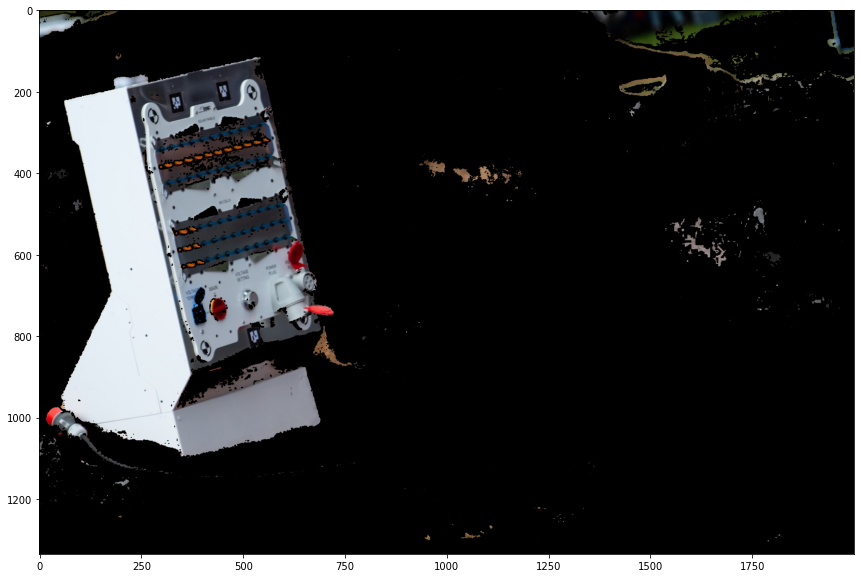

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

###
# stream acquisition function, by path/address
def sourceType(srcBgVS,srcMode='single'):
    if srcMode=='single':
        return cv.imread(srcBgVS)
    elif srcMode=='video':
        cap = cv.VideoCapture(srcBgVS)
        if cap.isOpened():
            _, capFrame = cap.read()
        cap.release()
        return capFrame

################################
# source definition
srcMet=('single',
          'multiple',
          'video')
srcMetChoo=srcMet[0]

if srcMetChoo=='single':
    srcImgLib='../../images/marsyard/'
    srcImgPath=srcImgLib+'taskfinal.jpg'
    # source acquisition
    srcImg=sourceType(srcImgPath)
    
#_rework by creating src array to go threough later
# elif roiMetChoo=='multiple':
#     srcImgLib='../../images/marsyard/other_src/'
#     for srcImgPath in glob.glob(srcImgLib+"*.jpg"):
#         source acquisition
#         img=bgVStream(srcImgPath)
#         foreground=img.copy()
        # source prefiltering
#         imgh=bgPreFilt(img)
        # source histogram
#         imghhist = cv.calcHist([imgh], channels, None, histSize, ranges, accumulate=False)
#         cv.normalize(imghhist, imghhist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

else:
    srcImgLib='../../images/video/'
    srcImgPath=srcImgLib+'task_ext.avi'
    srcImg=sourceType(srcImgPath,'video')
    srcImg=srcImg[:,:(srcImg.shape[1])//2]

foreImg=panelFy(srcImg)

#plt.figure(figsize=(20,10))
# foreground, with removed background
plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(foreImg,cv.COLOR_BGR2RGB))
plt.show()
#background=srcImg-foreground

#cv.imwrite('../../images/panel/panelmini.jpg',foreground)

## ADDENDUM

### on image prefiltering

### on roi acquisition

to reduce computation load, sample could be tested to avoid too much similarity with the previous one, harming the mean value (this part is deprecated since histogram stacking is no longer considered)

histogram stacking and averaging doesn't seem a good method, since more mask are simpler

final code should include samples from library, automatic and manual selection from stream;

automatic selection: regular grid on image and testing on correlation between them; random points and accretion of areas, with test on correlation; dimension/number of rois adaptivity wrt source features( biggest contours, watershed results, largest contiguous similar regions)

**improving:** correlate between themselves the regions inside the small section of the grid, by the means of a stactionary grid; use a moving grid where each section swipes between various regions and accumulates "points" when correlation is enough, maybe stacking the images (or averaging them), or anyway storing data on good regions (how to define good though? maybe this can be a refinement step once first background patches are estimated)

### on histograms and correlation test

V channel excluded because it's heavily influenced by light/environment conditions

V channel ranges, bins, max value could be toggles

still H,S channel are device dependent, LAB space in indipendent

in opencv H €[0,179], while S,V €[0,255]

### on mask and parameters



In [ ]:
# code to add for others roi selection methods 
    
    #    elif extrMetStream=='random':
 #       roih=50
  #      roiw=50
   #     for (centerx,centery) in centers:
    #        #centerx,centery=func2extractcenter(image)
     #       roimg=image[centery-roih//2:centery+roih//2,centerx-roiw//2:centerx+roiw//2]
      #      roi.append(cv.cvtColor(roimg, cv.COLOR_BGR2HSV))
       #     interpolation=np.median
        #    roistack=np.stack(roi,axis=0)
         #   roimean=interpolation(roistack,axis=0)
    #elif extrMetStream=='manual':

# FOREGROUND MASK IMPROVING



In [2]:
####
# MASK IMPROVEMENT
#    biggest contiguous region (as it could be the panel)
#    foreground filtering?
#    mini blobs remotion, especially in less/most transformed areas
#



####
# FOREGROUND TRACKING AND MASK ITERACTION
#    foreground histogram
#    foreground backprojection mask
#    foreground tracking with camshift
#    iterated foreground mask by tracking
#    total mask by summing back/foreground ones
#    new foreground identification and iteraction
## minAreaRect(maxContour) to identificate panel after masking


In [1]:
def bgForeImprov(srcFI,paramgbFI=6):
    #return srcFI
    kernel=cv.getStructuringElement(cv.MORPH_RECT,(paramgbFI,paramgbFI))
    morphed=cv.morphologyEx(srcFI,cv.MORPH_CLOSE,kernel)
    return cv.morphologyEx(morphed,cv.MORPH_RECT,kernel)

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
  
##result of previous code coventiently modified as if robot not present
foreground=cv.imread('../../images/panel/extpaneltask_real.jpg')
foreground=bgForeImprov(foreground)


**issues:** biggest contour open even after dilation operation (and various other ones); hence, the smallest region completely encapsulatin it is the convex hull, which includes also blobs/pixels from outside the panel and **a lot of black pixels**, which harm the camshift (since mask creates a black background)

try to exclude black pixels from histogram

### further mask refinement

**moved to motion simulation and tracking**
part which removed everything outside [hull of] max area/length contour found, has been moved to foreground tracking and motion control, since that code is needed to extract the roi; this will avoid redundancy once code will the joined together

https://docs.opencv.org/master/de/df4/tutorial_js_bg_subtraction.html

https://docs.opencv.org/master/d1/dc5/tutorial_background_subtraction.html

using background subtraction library, calculating background as the mean of various images (i.e. extracted frames from a video of the surraounding **for consultation purpose only**

https://derindelimavi.blogspot.com/2013/08/hareketli-kameradan-hareketli-nesne.html

moving object tracking by moving camera with :
feature detection
matching
???
homografy
contours and image difference

### background remotion on a video

basically the same, in a loop each time considering the folowing frame/current input